[nn.Transformer 와 torchtext로 seq2seq 모델링](https://tutorials.pytorch.kr/beginner/transformer_tutorial.html)

## seq2seq 모델링

* `nn.transformer` 를 이용한 seq2seq 모델 학습 방법

Transformer

1. 병렬화
2. 더 나은 성능

![](https://tutorials.pytorch.kr/_images/transformer_architecture.jpg)

## 모델 정의

In [1]:
"""
nn.TransformerEncoder 모델을 LM 에 대해 학습
    ㄴ 여러 개의 nn.TransformerEncoderLayer 로 구성
    ㄴ LM 태스크를 위해 마스킹 필요
    1. 토큰들의 시퀀스가 임베딩 레이어로 전달
    2. 포지셔널 인코딩 레이어가 순서를 설명
    3. 실제 단어를 얻기 위해 출력이 log-Softmax로 이어지는 최종 선형 레이어로 전달
"""

import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):
    def __init__(self,
                 ntoken: int,
                 d_model: int,
                 nhead: int,
                 d_hid: int,
                 nlayers: int,
                 dropout: float=0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arg:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output =self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    # Generates an upper-triangular matrix of ``-int``, with zeros on ``diag``.
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [3]:
# PositionalEncoding 모듈: 시퀀스 내부의 포지션 정보 주입
#   ㄴ 임베딩과 합칠 수 있도록 동일한 차원을 가진다
#   ㄴ 다른 주파수의 sin, cosine 함수 사용

class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
!pip install portalocker
# torchtext 데이터셋 접근 위함

## 데이터 로드 및 배치 생성

vocab: train dataset에 의해 생성,\
토큰을 텐서로 수치화하는데 사용

Wikitext-2에서 rare 토큰은 \<unk> 로 표현

`batchify()` 함수: 데이터를 `batch_size` 컬럼들로 정렬

예)

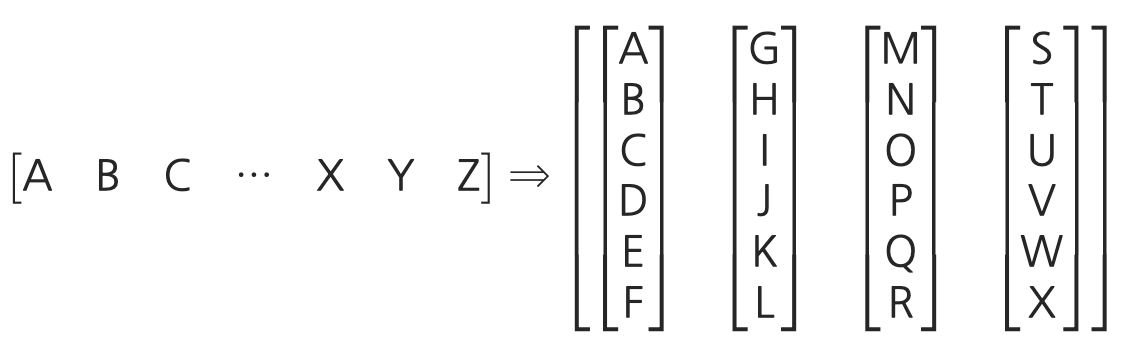

In [9]:
# 배치 작업
#   ㄴ 더 많은 병렬 처리
#   ㄴ 독립적으로 각 컬럼 취급

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    # Converts raw text into a flat Tensor
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]

    # data 내에서 원소가 있는 것들만 필터링
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter: consumed by the process of building the vocab
# so have to create it again

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides data into ``bsz`` seperate sequences, removing extra
    elements that wouldn't cleanly fit

    Args:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]

    # view, transpose, permute 등 `메타데이터` 만 변경하는 함수들의 결과값은 non-contiguous
    # 이는 주소값 재배열 연산이 필요할 때 사용할 수 없다
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

## 입력과 타겟 시퀀스 생성을 위한 함수

In [15]:
"""
get_batch()
    ㄴ 트랜스포머 모델을 위한 입력-타겟 시퀀스 쌍 생성
    ㄴ 소스 데이터를 bptt 길이를 가진 덩어리로 세분화
    ㄴ LM 태스크를 위해 모델은 다음 단어인 Target을 필요로 함
"""

bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple ``(data, target)``, where data has shape ``[seq_len, batch_size]``
        and target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1: i+1+seq_len].reshape(-1)
    return data, target

## 인스턴스 초기화

In [16]:
# 모델의 하이퍼파라미터 정의

ntokens = len(vocab) # vocab 크기
emsize = 200
d_hid = 200 # FFN dimension
nlayers = 2
nhead = 2
dropout = 0.2
model = TransformerModel(ntokens,
                         emsize,
                         nhead,
                         d_hid,
                         nlayers,
                         dropout).to(device)

## 모델 실행

In [17]:
# CrossEntropyLoss, SGD
# lr=5.0, StepLR schedule ++ nn.utils.clip_grad_norm_

import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [18]:
def train(model: nn.Module) -> None:
    model.train()
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)

        if seq_len != bptt: # last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [19]:
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
        return total_loss / (len(eval_data) - 1)

In [20]:
best_val_loss = float('inf')
epochs = 3

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)

        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed: 5.2f}s |'
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()

    # load best model states
    model.load_state_dict(torch.load(best_model_params_path))

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 29.89 | loss  8.08 | ppl  3224.20
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 13.69 | loss  6.83 | ppl   923.06
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 14.41 | loss  6.41 | ppl   607.40
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 13.76 | loss  6.28 | ppl   535.33
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 13.72 | loss  6.18 | ppl   484.36
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 13.74 | loss  6.15 | ppl   467.23
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 14.25 | loss  6.11 | ppl   448.51
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 14.00 | loss  6.10 | ppl   446.20
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 13.73 | loss  6.03 | ppl   414.09
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 13.78 | loss  6.01 | ppl   409.41
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 14.38 | loss  5.90 | ppl   366.31
| epoch   1 |  2400/ 

## 평가 데이터셋으로 모델 평가하기

In [21]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} |'
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.52 |test ppl   250.41
